# 1. Libraries

In [12]:
import pandas as pd
import numpy as np
import os
import math
import time
import itertools
import datetime
from datetime import datetime
import seaborn as sns

import string
from wordcloud import STOPWORDS

from scipy.stats import skew, boxcox
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# xgboost
import xgboost as xgb

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Configuration

In [13]:
output_featimp = 'feat_xgb_v17_reglinear_rooty.csv'
output_sub     = 'sub_xgb_v17_reglinear_rooty.csv'
output_oof     = 'oof_xgb_v17_reglinear_rooty.csv'

root = 2

ID = 'tweet_id'
TARGET = 'engagement_count'
NFOLDS = 5
SEED = 2023
NROWS = None
DATA_DIR = "../input"

TRAIN_FILE = "{0}/expert_training.csv".format(DATA_DIR)
TEST_FILE = "{0}/expert_testing.csv".format(DATA_DIR)
SUBMISSION_FILE = "{0}/expert_samplesubmission.csv".format(DATA_DIR)

params = {
    'seed': 0,
    'booster': 'gbtree', # gbtree, gblinear or dart
    'objective': 'reg:linear', # count:poisson, reg:linear, reg:squarederror, reg:squaredlogerror, reg:absoluteerror, reg:gamma, reg:tweedie
    'learning_rate': 0.01, # default=0.3
    'max_depth': 12, # default=6
    'min_child_weight': 10, # default=1
    'subsample': 0.9, # default=1
    'colsample_bytree': 0.8, # default=1
#     'gamma': 0, # default=0
#     'lambda': 1, # default=1
#     'alpha': 0, # default=0
    }

# 3. Functions

In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def xg_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(((yhat - y) ** 2).mean())

# 4. Data

In [15]:
# read data
train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
test = pd.read_csv(TEST_FILE, nrows=NROWS)

# fill test target
test[TARGET] = 0

# name + text
train['name_time_text'] = train['screen_name'] + " " + train['created_at'] + " "  + train['full_text']
test['name_time_text']  = test['screen_name']  + " " + test['created_at']  + " "  + test['full_text']

# drop duplicates (the first one will be kept)
train_df = train.drop_duplicates(subset=['name_time_text'])
test_df  = test.drop_duplicates(subset=['name_time_text'])

# train test indicator
train_df['train_test'] = 'train'
test_df['train_test']  = 'test'

# concat
train_test_df = pd.concat([train_df, test_df], axis=0)

# flag for duplicated one (last one(test) will have "True")
train_test_df['in_train'] = train_test_df['name_time_text'].duplicated()

# add "in_train" flag to original test data
in_train_df = train_test_df.loc[train_test_df['in_train']]
in_train_df = in_train_df[['name_time_text','in_train']]
test = test.merge(in_train_df, on='name_time_text', how='left')
test['in_train'] = test['in_train'].fillna(False)

# set aside train_test_df after removing duplicates (the first one(train) will be kept). It will be used for feature engineering
train_test_df = train_test_df[~train_test_df['in_train']]

# separate test "in train' and 'not in train'
test_in_train = test[test['in_train']]
test_not_in_train = test[~test['in_train']]

# get target values from train_df
test_in_train = test_in_train.drop([TARGET], axis=1)
test_in_train = test_in_train.merge(train_df[['name_time_text',TARGET]], on='name_time_text', how='left')

# get # of rows
ntrain = train_df.shape[0]
ntest = test_not_in_train.shape[0]

# drop_index
test_not_in_train = test_not_in_train.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# get id and target
id_train = train_df[ID]
id_test = test_not_in_train[ID]
y_train = train_df[TARGET]**(1/root)

# make them have the same columns
test_not_in_train = test_not_in_train.drop(['in_train'], axis=1)
test_not_in_train['train_test'] = 'test'

# concatenate train and test
train_test = pd.concat([train_df, test_not_in_train]).reset_index(drop=True)

C:\Users\kkudo\AppData\Local\Temp\ipykernel_12392\225736481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_test'] = 'train'
C:\Users\kkudo\AppData\Local\Temp\ipykernel_12392\225736481.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['train_test']  = 'test'


# 5. Preprocessing

##### train_test:   train does not have duplicates, but test has duplicates
##### train_test_df:it does not have duplicates. It will be used for feature engineering

In [16]:
names = ['songmyeongho1',
 'web3_inu',
 'ethereum',
 'NFTcollector00',
 'web3',
 'PulsechainCom',
 'Bitcoin',
 'magicianpromos',
 'cryptoBILLnfts',
 'cryptopunksnfts',
 'cryptoworld_gg',
 'russnft',
 'Crypto_Inside_',
 'DeGodsNFT',
 'BabyDogeNFTs',
 'CryptoCapo_',
 'MrsunNFT',
 'kris',
 'AnuelNFT',
 'cryptocom',
 'NftCryptosArt']

# train_test.query(f'screen_name in {names}')
train_test.loc[train_test['screen_name'].isin(names),'highprofile'] = 1
train_test['highprofile'] = train_test['highprofile'].fillna(0)
train_test['highprofile'] = train_test['highprofile'].astype(int)

train_test_df.loc[train_test_df['screen_name'].isin(names),'highprofile'] = 1
train_test_df['highprofile'] = train_test_df['highprofile'].fillna(0)
train_test_df['highprofile'] = train_test_df['highprofile'].astype(int)

In [17]:
X = pd.DataFrame()

# screen_name
X['highprofile'] = train_test['highprofile']
# X['highprofile'] = X['highprofile'].astype(int)

## created at
# convert 'created_at' from object to datetime
train_test['created_at'] = pd.to_datetime(train_test['created_at'])
train_test['dayname'] = train_test['created_at'].dt.strftime('%A')
train_test['date'] = pd.to_datetime(train_test['created_at']).dt.date
train_test['yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month
train_test['year'] = pd.to_datetime(train_test['created_at']).dt.year

train_test_df['created_at'] = pd.to_datetime(train_test_df['created_at'])
train_test_df['dayname'] = train_test_df['created_at'].dt.strftime('%A')
train_test_df['date'] = pd.to_datetime(train_test_df['created_at']).dt.date
train_test_df['yrmonth'] = (pd.to_datetime(train_test_df['created_at']).dt.year-2013)*12+pd.to_datetime(train_test_df['created_at']).dt.month
train_test_df['year'] = pd.to_datetime(train_test_df['created_at']).dt.year


# ymd
X['created_at_year'] = pd.to_datetime(train_test['created_at']).dt.year
X['created_at_month'] = pd.to_datetime(train_test['created_at']).dt.month
X['created_at_yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month

# day name
tmp = pd.get_dummies(train_test['dayname'], prefix='dayname', prefix_sep='_')
X = pd.concat([X, tmp], axis=1)

# le = LabelEncoder()
# X['dayname']= le.fit_transform(train_test['dayname'])


## full text
# count of words
X['count_words'] = train_test['full_text'].str.split().map(lambda x: len(x))

# count of characters
X['count_chars'] = train_test['full_text'].str.len()

# count of unique workds
X['unique_word_count'] = train_test['full_text'].apply(lambda x: len(set(str(x).split())))

# count of stop word
X['stop_word_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
X['url_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
X['mean_word_length'] = train_test['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
X['punctuation_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
X['hashtag_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
X['mention_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))


## tweet frequency - for aggregation, make sure to use "train_test_df" (not "train_test")
# same day
tmp = train_test_df.groupby(['screen_name','date'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={"full_text": "tweet_count_same_day"})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','date'])
train_test['tweet_count_same_day'] = train_test['tweet_count_same_day'].fillna(0)
X['tweet_count_same_day'] = train_test['tweet_count_same_day']

# same month
tmp = train_test_df.groupby(['screen_name','yrmonth'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_month'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','yrmonth'])
train_test['tweet_count_same_month'] = train_test['tweet_count_same_month'].fillna(0)
X['tweet_count_same_month'] = train_test['tweet_count_same_month']

# same year
tmp = train_test_df.groupby(['screen_name','year'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_year'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','year'])
train_test['tweet_count_same_yearonth'] = train_test['tweet_count_same_year'].fillna(0)
X['tweet_count_same_year'] = train_test['tweet_count_same_year']


## display_text_range
X['display_text_range'] = train_test['display_text_range']
# X['display_text_range_bin'] = pd.cut(train_test['display_text_range'], bins=10, labels=False)

## in_reply_to_screen_name
X['in_reply_to_screen_name_flg'] = train_test['in_reply_to_screen_name'].apply(lambda x : 0 if x is np.nan else 1)


## is_quote_status
X['is_quote_status'] = train_test['is_quote_status'].apply(lambda x : 1 if x else 0)


## includes_media
X['includes_media'] = train_test['includes_media'].apply(lambda x : 1 if x else 0)


## hashtags
#X['hashtag_count'] = len(train_test['hashtags'].split(', '))
X['hashtag_Bitcoin'] = train_test['hashtags'].str.contains('Bitcoin')
X['hashtag_Bitcoin'] = X['hashtag_Bitcoin'].apply(lambda x : 1 if x else 0)

X['hashtag_Crypto'] = train_test['hashtags'].str.contains('Crypto')
X['hashtag_Crypto'] = X['hashtag_Crypto'].apply(lambda x : 1 if x else 0)


## user_mentions
X['user_mentions_flg'] = train_test['user_mentions'].apply(lambda x : 0 if x is np.nan else 1)

In [18]:
# sentimental analysis scores
sent = pd.read_csv('../00_SentimentAnalysis/sentiment_analysis_scores3.csv', nrows=NROWS)

train_test = train_test.merge(sent, on='tweet_id', how='left')
X['sent_score'] = train_test['sent_score']
X['sent_label_NEG'] = train_test['sent_label_NEG']
X['sent_label_NEU'] = train_test['sent_label_NEU']
X['sent_label_POS'] = train_test['sent_label_POS']

In [19]:
# followers
fol = pd.read_csv('../00_EDA/screen_names_followers.csv', nrows=NROWS)

train_test = train_test.merge(fol, on='screen_name', how='left')
X['followers'] = train_test['followers']

In [20]:
# separate train and test
x_train = X.iloc[:ntrain,:]
x_test = X.iloc[ntrain:,:]

In [21]:
## OOF target
oof_nfolds = 10

kfold = KFold(n_splits=oof_nfolds, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((oof_nfolds, ntest))


for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
    tr_df = train_df.iloc[train_idx]
    vl_df = train_df.iloc[valid_idx]
    
    # screen_name
    tmp = tr_df.groupby(['screen_name'])[TARGET].mean()
    tmp = pd.DataFrame(tmp).reset_index().rename(columns={TARGET: 'oof_screen_name'})
    tmp_mean = tr_df[TARGET].mean()
    
    a = vl_df[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_train[valid_idx] = a['oof_screen_name']
    
    a = test_not_in_train[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_test_skf[fold_id, :] = a['oof_screen_name']
    
oof_test[:] = oof_test_skf.mean(axis=0)


x_train['oof_screen_name'] = oof_train
x_test['oof_screen_name'] = oof_test

C:\Users\kkudo\AppData\Local\Temp\ipykernel_12392\1776465337.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['oof_screen_name'] = oof_train
C:\Users\kkudo\AppData\Local\Temp\ipykernel_12392\1776465337.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['oof_screen_name'] = oof_test


# 5. Cross Validation

In [22]:
# modeling with cross validation
# kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
kfold = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((NFOLDS, ntest))

feat_imp = np.zeros((NFOLDS,x_train.shape[1]))

d_test = xgb.DMatrix(x_test)

for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(x_train)):
    
    print("\nFold %d / %d" % (fold_id + 1, NFOLDS))

    d_train = xgb.DMatrix(x_train.iloc[train_idx], label=y_train[train_idx])
    d_valid = xgb.DMatrix(x_train.iloc[valid_idx], label=y_train[valid_idx])
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(params,
                      d_train,
                      100000,
                      evals=watchlist,
                      verbose_eval = 100,
                      early_stopping_rounds=50,
#                       obj=fair_obj,
                      custom_metric=xg_eval_rmse)
    
    oof_train[valid_idx] = model.predict(d_valid, ntree_limit=model.best_ntree_limit)**(root)
    oof_test_skf[fold_id, :] = model.predict(d_test, ntree_limit=model.best_ntree_limit)**(root)

    feat_imp_out = model.get_score(importance_type='gain')
    for i,x in enumerate(model.get_score(importance_type='gain')):
        feat_imp[fold_id,i] = feat_imp_out[x]
    
oof_test[:] = oof_test_skf.mean(axis=0)

# fill negative with 0
oof_train[oof_train<0] = 0
oof_test[oof_test<0] = 0

feat_imp = feat_imp.mean(axis=0)
feat_imp = pd.DataFrame(sorted(zip(feat_imp, x_train.columns),reverse = True), columns=['Gain','Feature'])
feat_imp.to_csv(output_featimp, index=False)

# OOF RMSE
print('\nOOF RMSE: {:.4f}'.format(rmse(oof_train, y_train**(root))))

print('OOF RMSE in 0:24069:   {:.4f}'.format(rmse(oof_train[0:24069], y_train[0:24069]**(root))))
print('OOF RMSE in 24069:END: {:.4f}'.format(rmse(oof_train[24069:], y_train[24069:]**(root))))


Fold 1 / 5
[18:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.16573	eval-rmse:10.84780
[100]	train-rmse:6.29730	eval-rmse:7.15585
[200]	train-rmse:4.51965	eval-rmse:6.18777
[300]	train-rmse:3.76956	eval-rmse:5.93520
[400]	train-rmse:3.39577	eval-rmse:5.82528
[500]	train-rmse:3.17037	eval-rmse:5.77884
[600]	train-rmse:3.01639	eval-rmse:5.75364
[700]	train-rmse:2.90223	eval-rmse:5.73994
[800]	train-rmse:2.81176	eval-rmse:5.72611
[900]	train-rmse:2.72833	eval-rmse:5.71940
[966]	train-rmse:2.67386	eval-rmse:5.72028

Fold 2 / 5
[18:35:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.03418	eval-rmse:11.37656


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.28193	eval-rmse:7.18560
[200]	train-rmse:4.51743	eval-rmse:6.13406
[300]	train-rmse:3.75519	eval-rmse:5.90977
[400]	train-rmse:3.36680	eval-rmse:5.84626
[500]	train-rmse:3.13024	eval-rmse:5.83653
[512]	train-rmse:3.10896	eval-rmse:5.83373

Fold 3 / 5
[18:36:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.05636	eval-rmse:11.29425


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.25502	eval-rmse:7.29865
[200]	train-rmse:4.46014	eval-rmse:6.25610
[300]	train-rmse:3.66843	eval-rmse:5.98921
[400]	train-rmse:3.27835	eval-rmse:5.91925
[500]	train-rmse:3.04091	eval-rmse:5.87782
[600]	train-rmse:2.89126	eval-rmse:5.85754
[700]	train-rmse:2.77592	eval-rmse:5.84441
[800]	train-rmse:2.67028	eval-rmse:5.84080
[899]	train-rmse:2.58547	eval-rmse:5.83533

Fold 4 / 5
[18:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.12228	eval-rmse:11.03173


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.31696	eval-rmse:6.95812
[200]	train-rmse:4.53474	eval-rmse:5.96162
[300]	train-rmse:3.76478	eval-rmse:5.75602
[400]	train-rmse:3.36887	eval-rmse:5.70996
[500]	train-rmse:3.12814	eval-rmse:5.69584
[600]	train-rmse:2.97165	eval-rmse:5.69001
[660]	train-rmse:2.88288	eval-rmse:5.69461

Fold 5 / 5
[18:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.13220	eval-rmse:10.99453


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-rmse:6.33663	eval-rmse:6.98659
[200]	train-rmse:4.57736	eval-rmse:5.94009
[300]	train-rmse:3.82159	eval-rmse:5.69032
[400]	train-rmse:3.43659	eval-rmse:5.62669
[500]	train-rmse:3.19352	eval-rmse:5.60163
[600]	train-rmse:3.02296	eval-rmse:5.57726
[700]	train-rmse:2.88376	eval-rmse:5.56513
[800]	train-rmse:2.77234	eval-rmse:5.54751
[900]	train-rmse:2.67550	eval-rmse:5.53676
[1000]	train-rmse:2.57014	eval-rmse:5.52705
[1100]	train-rmse:2.48988	eval-rmse:5.52074
[1200]	train-rmse:2.41461	eval-rmse:5.51876
[1235]	train-rmse:2.38675	eval-rmse:5.51785

OOF RMSE: 821.7931
OOF RMSE in 0:24069:   150.7149
OOF RMSE in 24069:END: 2669.0206


D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Text(0, 0.5, 'actual')

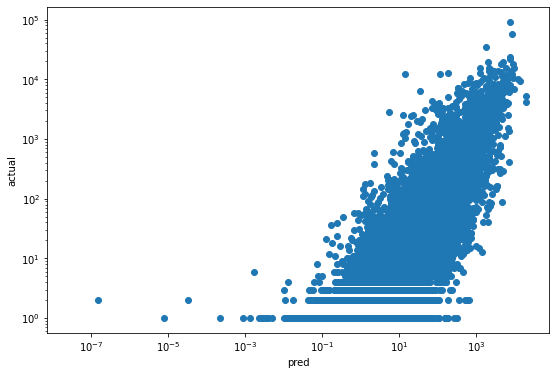

In [23]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train, y_train**root)
plt.xlabel('pred')
plt.ylabel('actual')

Text(0, 0.5, 'actual')

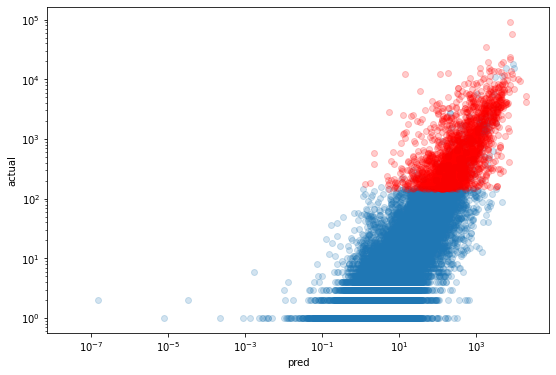

In [24]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train[0:24069], y_train[0:24069]**root, alpha=0.2)
plt.scatter(oof_train[24069:], y_train[24069:]**root, alpha=0.2, color='red')
plt.xlabel('pred')
plt.ylabel('actual')

# 6. Submission

In [27]:
# oof
oof = pd.DataFrame()
oof[ID] = id_train
oof[TARGET] = oof_train
oof['actual'] = y_train**root
oof.loc[oof[TARGET]<0, TARGET] = 0
oof.to_csv(output_oof, index=False)

In [28]:
oof.shape

(26505, 3)

In [26]:
### submission
# not_in_train
sub = pd.DataFrame()
sub[ID] = id_test
sub[TARGET] = oof_test

# in_train
sub = pd.concat([sub, test_in_train[[ID, TARGET]]], axis=0)
sub = sub.sort_values(by=[ID])
sub.loc[sub[TARGET]<0, TARGET] = 0

# save
sub.to_csv(output_sub, index=False)

# ...END